In [5]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [6]:
# Read data from CSV file
df = pd.read_csv("winequality-red.csv", sep=';')

Dataset characteristics

Number of Records: 1599


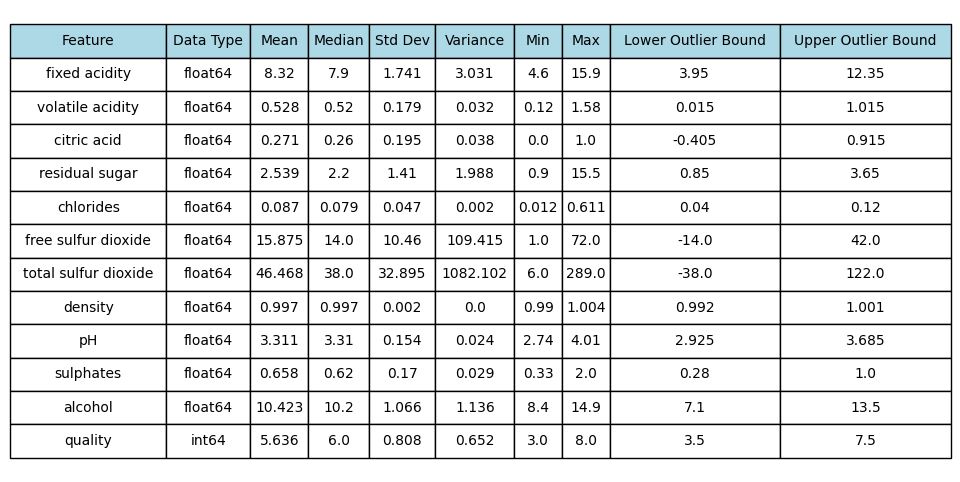

In [23]:
# Number of records
num_records = df.shape[0]
print("Number of Records:", num_records)

# Mean of each feature
feature_means = df.mean()

# Create a new dataframe for feature statistics
feature_stats = pd.DataFrame(columns=['Feature', 'Data Type', 'Mean', 'Median', 'Std Dev', 'Variance', 'Min', 'Max', 'Lower Outlier Bound', 'Upper Outlier Bound'])

# Iterate through each feature
for feature_name in df.columns:
    # Data type
    data_type = df[feature_name].dtype
    
    # Mean
    mean_value = feature_means[feature_name]
    
    # Median
    median_value = df[feature_name].median()
    
    # Standard deviation
    std_dev_value = df[feature_name].std()
    
    # Variance
    variance_value = df[feature_name].var()
    
    # Minimum
    min_value = df[feature_name].min()
    
    # Maximum
    max_value = df[feature_name].max()
    
    Q1 = df[feature_name].quantile(0.25)
    Q3 = df[feature_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    lower_outlier = lower_bound
    upper_outlier = upper_bound
    
    # Append to the new dataframe
    feature_stats.loc[len(feature_stats)] = [feature_name, data_type, mean_value, median_value, std_dev_value, variance_value, min_value, max_value, lower_outlier, upper_outlier]

feature_stats = feature_stats.round(3)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
table_data = feature_stats.values
headers = feature_stats.columns
table = ax.table(cellText=table_data, colLabels=headers, cellLoc = 'center', loc='center')

table.auto_set_column_width(col=list(range(len(headers))))
table.scale(1,2)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)

for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_facecolor('#add8e6')
        
plt.savefig("figs/data_qualities.png")
plt.show()


plot quality distribution

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['quality'], bins=range(1, 11), color='skyblue')
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("figs/qual_distribution.png")
plt.show()

generate dataset with features scaled

In [ ]:
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

scaled_df["quality"] = df["quality"]
scaled_df.to_csv('feature_scaled_dataset.csv', index=False)

Find dataset Outliers

In [ ]:
# Columns to exclude from outlier detection
exclude_columns = ['quality']

# Identify potential outliers in each column
outliers_dict = {}

for column in df.columns:
    if column not in exclude_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        # Add column name to the associated array for each outlier record
        for index, row in outliers.iterrows():
            if index not in outliers_dict:
                outliers_dict[index] = []
            outliers_dict[index].append(column)

multi_outliers = 0


mean = 0
# Display potential outliers and associated columns
for record_index, associated_columns in outliers_dict.items():
    if len(associated_columns) > 2:
        multi_outliers += 1
        mean += df.loc[record_index]["quality"]
        #print(f"\nPotential Outlier in Record {record_index}:")
        #print(f"Associated Columns: {', '.join(associated_columns)}")
        #print(df.loc[record_index])

mean = mean / multi_outliers

print(mean)
print(multi_outliers)

Analyse Top 10 Records, Bottom 10 records, and median 10 records

In [54]:
# Assuming your DataFrame is named df
df_sorted = df.sort_values(by='quality', ascending=False)

# Function to identify outliers in a given column
def identify_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (column < lower_bound) | (column > upper_bound)
    return outliers

# Iterate through each feature
for feature in df_sorted.columns:
    # Add a feature indicating whether the value is an outlier over the upper bound
    df_sorted[f"{feature}_upper_outlier"] = identify_outliers(df_sorted[feature])

    # Add a feature indicating whether the value is an outlier over the lower bound
    df_sorted[f"{feature}_lower_outlier"] = identify_outliers(df_sorted[feature])

# Add a feature for each record indicating the number of outliers
df_sorted['num_outliers'] = df_sorted.filter(like='_outlier').sum(axis=1)

print(f'Average number of outliers: {df_sorted["num_outliers"].mean()}')
# Print the top 10 records
print("Top 10 Records:")
print(df_sorted.head(10))

# Print the bottom 10 records
print("\nBottom 10 Records:")
print(df_sorted.tail(10))

# Print the median 10 records
print("\nMedian 10 Records:")
median_index = len(df_sorted) // 2
median_records = df_sorted.iloc[median_index - 5 : median_index + 5]  # Assuming an odd number of rows
print(median_records)

Average number of outliers: 0.7517198248905566
Top 10 Records:
      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
495            10.7              0.35         0.53             2.6      0.070   
1403            7.2              0.33         0.33             1.7      0.061   
390             5.6              0.85         0.05             1.4      0.045   
1061            9.1              0.40         0.50             1.8      0.071   
1202            8.6              0.42         0.39             1.8      0.068   
828             7.8              0.57         0.09             2.3      0.065   
481             9.4              0.30         0.56             2.8      0.080   
455            11.3              0.62         0.67             5.2      0.086   
1449            7.2              0.38         0.31             2.0      0.056   
440            12.6              0.31         0.72             2.2      0.072   

      free sulfur dioxide  total sulfur dioxi

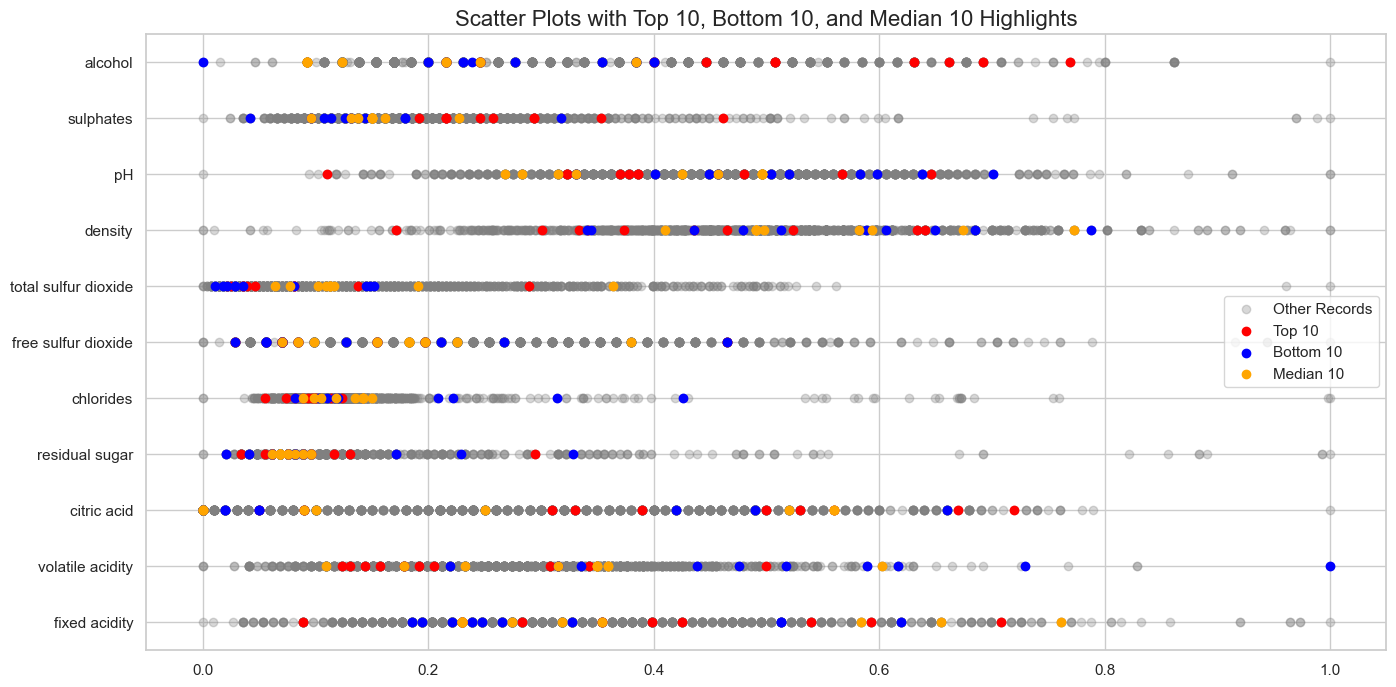

In [59]:
# Assuming your DataFrame is named scaled_df
plots = scaled_df.sort_values(by='quality', ascending=False).drop(columns=["quality"])

# Set the size of the plot
plt.figure(figsize=(16, 8))

# Iterate through each feature
for feature in plots.columns:
    # Scatter plot for all records in grey
    plt.scatter(x=plots[feature], y=[feature] * len(plots), c="grey", alpha=0.3, label="Other Records" if feature == plots.columns[0] else "")

    # Highlight the top 5 records in red
    plt.scatter(x=plots.head(10)[feature], y=[feature] * 10, c="red", marker="o", label="Top 5" if feature == plots.columns[0] else "")

    # Highlight the bottom 5 records in blue
    plt.scatter(x=plots.tail(10)[feature], y=[feature] * 10, c="blue", marker="o", label="Bottom 5" if feature == plots.columns[0] else "")

    # Highlight the median 5 records in orange
    median_index = len(plots) // 2
    plt.scatter(x=plots.iloc[median_index - 5 : median_index + 5][feature], y=[feature] * 10, c="orange", marker="o", label="Median 5" if feature == plots.columns[0] else "")

# Set the title for the entire plot
plt.title("Scatter Plots with Top 10, Bottom 10, and Median 10 Highlights", fontsize=16)

# Show legend with specified labels
plt.legend(["Other Records", "Top 10", "Bottom 10", "Median 10"])

plt.savefig("figs/extreme_record_outlier_visualisation.png")
# Show the plot
plt.show()


create box plots for data to identify outliers/ distribution

In [ ]:
plots = scaled_df.drop(columns=["quality"])

sns.set(style="whitegrid")

# Set the size of the plot
plt.figure(figsize=(16, 8))

# Plot box plots for each feature
sns.boxplot(data=plots, orient="h", palette="Set2")

# Set the title
plt.title("Box Plot for Each Feature", fontsize=16)

plt.savefig("figs/feature_boxplot_distributions.png")
# Show the plot
plt.show()

generate correlation matrix and associated figure

In [ ]:
# make correlation matrix
correlation_matrix = df.corr()

#show correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.tight_layout()
plt.savefig("figs/correlation_matrix.png")
plt.show()

Generate VIF values

In [ ]:
vif_data = pd.DataFrame()
vif_data["Variable"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

# Display VIF values
print(vif_data)

combine correlated variables to produce new dataset

In [ ]:
feature_comb_data = df
feature_comb_data["combined acidity"] = feature_comb_data["fixed acidity"] * feature_comb_data["pH"] * feature_comb_data["citric acid"]
feature_comb_data = feature_comb_data.drop(columns=["fixed acidity", "citric acid", "pH"])
feature_comb_data.to_csv('combined_acid_dataset.csv', index=False)
print(feature_comb_data)

Generate covariance matrix and eigen decomposition

In [ ]:
numeric_data = df.drop(columns=["quality"])

# Calculate the covariance matrix
cov_matrix = np.cov(numeric_data, rowvar=False)

# Calculate the eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

percentage_contribution = np.round((eigenvalues / np.sum(eigenvalues)) * 100, decimals=2)

print("Eigen Values for All Covariance Eigenvectors:\n")
# Display the eigenvalues for all features
for i, eigenvalue in enumerate(eigenvalues):
    feature_name = numeric_data.columns[i]
    print(f"Eigenvalue for EigenVector {i+1}: {eigenvalue} ({percentage_contribution[i]}%)\n")

Generate PCA reduced dataset

In [ ]:
# Sort eigenvalues and corresponding eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Number of components to keep (e.g., choose the number of components based on explained variance)
num_components = 2

# Create the projection matrix by selecting the top 2 eigenvectors which contribute 99.5% of total eigenvalue
projection_matrix = eigenvectors[:, :2]

# Transform the original dataset to a PCA-reduced dataset
pca_reduced_data = numeric_data.dot(projection_matrix)

pca_reduced_data['quality'] = df['quality']  # Assuming 'quality' is the target column
pca_reduced_data.to_csv('pca_reduced_dataset.csv', index=False)

Create Pie chart to illustrate eigen significance

In [ ]:
# Plot the pie chart with distinct colors for each section
plt.figure(figsize=(8, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(eigenvalues)))  # Use a range of distinct colors
patches, texts, autotexts = plt.pie(eigenvalues, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)

# Create a color-coded legend with both feature name and percentage
legend_labels = [f"Eigenvector {i+1} ({percentage:.1f}%)"
                 for i, percentage in enumerate(percentage_contribution)]

for text in texts + autotexts:
    text.set_text("")

plt.legend(patches, legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.title('Percentage of Eigenvalue Significance', loc='left')
plt.tight_layout()
plt.savefig("figs/covariance_eigenvectors_pie.png")
plt.show()